<a href="https://colab.research.google.com/github/melissamelton/GSB521_CongressionalData/blob/main/Assignment_1b_US_Districts_Bachelors_Degrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Relationship Between Political Affiliation and Educational Paths Amongst Congressional Districts in the United States**


*By Melissa Melton (mnmelton@calpoly.edu) & Annika Bertelsen (abertels@calpoly.edu)*

February 9, 2023

As you may recall, our original presentation of political party affiliation and educational path taken by state was aimed to analyze the household income gap between Democratic and Republican congressional districts. Per Pierce's analysis of household incomes and political parties, we saw that Democratic congressional districts had a higher proportion of houses earning over $200k. In our original analysis, we looked at political affiliation and Science/Engineering degrees by state and hypothesized that based on Pierce's findings, Democratic states would have higher proportions of their population with a Science/Engineering degree since we considered this the most lucrative degree category.

To revamp our analysis, we have brought in all bachelor's degree categories recorded by American Community Survey for the total population over the age of 25 with a bachelor's or higher, as well as utilized the political affiliation data by congressional districts for all states. 

Note: the bachelor's degree categories Science/Engineering, Science/Engineering Related, Business, Education, and Arts/Humanities/Other were the predetermined categories provided by the ACS for respondents to select from. We are unsure the kind of specific degrees that respondents who selected Science/Engineering Related may have obtained.




**Hypothesis:** With the expansion of our analysis to include all BA Degree Categories reported by ACS, our hypothesis remains that the districts with a high proportion of the total population above 25 with a Bachelor's degree in Science or Engineering will likely be districts that have a Democratic affiliation. We propose the Science or Engineering Related category will maybe be about evenly split. We also hypothesize that the Business Degree Category will be dominated by Republican congressional districts across the US, while Education and Arts/Humanities will have more frequent BA Degrees out of the total population for Democratic districts.

This hypothesis is rooted in preconcieved notions/ sterotypes of Democratic vs Republican political affiliation with the idea that Democrats may value Education and Art/Humanity educational paths while Republicans might be more interested in a Business Degree route. Additionally, our hypothesis paralells the findings that Democratic districts have higher household earnings, since we believe Science and Engineering would be a high earning degree and therefore be higher in Democratic districts.

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from urllib.request import urlopen
import seaborn as sns
from statsmodels.stats.weightstats import ztest

# ACS Data on Bachelor's Degrees

Read in the data from ACS and perform initial cleaning.

ACS: https://www.census.gov/data/developers/data-sets/acs-1year.html

In [ ]:
# We are reading in the data we want from ACS 2021. The API returns json data.
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,C15010_001E,C15010_002E,C15010_003E,C15010_004E,C15010_005E,C15010_006E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0)

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Total','Total Science and Engineering', 'Total Science and Engineering Related', 'Total Business', 'Total Education', 'Total Arts, Humanities, and Other', 'State Code', 'District Number']

acs_df = pd.DataFrame(data_json, columns = cols)

# Extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['District Number'] = pd.to_numeric(acs_df['District Number'])

acs_df['State'] = acs_df['State'].str.strip()

# Keep only the columns we need. Keeping all Degree categories in version 1B vs. only Science/Engineering.
acs_df = acs_df[['Total', 'Total Science and Engineering', 'Total Science and Engineering Related', 'Total Business', 'Total Education', 'Total Arts, Humanities, and Other', 'District Number', 'State']]

acs_df.head()

,Total,Total Science and Engineering,Total Science and Engineering Related,Total Business,Total Education,"Total Arts, Humanities, and Other",District Number,State
0,129813,36613,13261,31155,22498,26286,1,Alabama
1,109507,34024,9084,25512,17721,23166,2,Alabama
2,126350,34503,16188,26092,21026,28541,3,Alabama
3,95245,24447,11817,19841,20422,18718,4,Alabama
4,193261,79051,15525,40084,23294,35307,5,Alabama


In [ ]:
# Make count data numeric
cols = ['Total', 'Total Science and Engineering', 'Total Science and Engineering Related', 'Total Business', 'Total Education', 'Total Arts, Humanities, and Other']
acs_df[cols] = acs_df[cols].apply(pd.to_numeric)

# Lambda function to convert the count of individuals in each district with each degree into a proportion of the district total
cols2 = ['Total Science and Engineering', 'Total Science and Engineering Related', 'Total Business', 'Total Education', 'Total Arts, Humanities, and Other']
acs_df[cols2] = acs_df[cols2].apply(lambda x: 100*x / acs_df['Total'])

# Rename columns
acs_df.columns = acs_df.columns.str.replace(r'Total ', '% ')

acs_df.head()

,Total,% Science and Engineering,% Science and Engineering Related,% Business,% Education,"% Arts, Humanities, and Other",District Number,State
0,129813,28.204417,10.215464,23.999908,17.331084,20.249128,1,Alabama
1,109507,31.070160,8.295360,23.297141,16.182527,21.154812,2,Alabama
2,126350,27.307479,12.812030,20.650574,16.641076,22.588841,3,Alabama
3,95245,25.667489,12.406950,20.831540,21.441545,19.652475,4,Alabama
4,193261,40.903752,8.033178,20.740863,12.053130,18.269077,5,Alabama


# Party Affiliation Data

Next, we will read in a dataset containing each congressional district's party affiliation for the 116th Congress. This data was scraped from the U.S. House of Representatives website and turned into a csv: http://goodcsv.com/politics/us-house-of-representatives-2020/

In [ ]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['District Number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['District Number'] = party_df['District Number'].fillna(0)
party_df['District Number'] = pd.to_numeric(party_df['District Number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['Party', 'State', "District Number"]]

party_df.head(5)

,Party,State,District Number
0,R,Louisiana,5
1,D,North Carolina,12
2,R,Alabama,4
3,D,California,31
4,R,Georgia,12


Merge the ACS and party dataframes by state and district number.

In [ ]:
merged_df = pd.merge(party_df, acs_df, on= ['State', 'District Number'])
merged_df.head()

,Party,State,District Number,Total,% Science and Engineering,% Science and Engineering Related,% Business,% Education,"% Arts, Humanities, and Other"
0,R,Louisiana,5,92291,25.232146,14.402271,17.113261,20.220823,23.031498
1,D,North Carolina,12,280999,32.912929,8.680814,26.359169,7.260524,24.786565
2,R,Alabama,4,95245,25.667489,12.406950,20.831540,21.441545,19.652475
3,D,California,31,127251,35.789896,11.392445,20.504358,8.426653,23.886649
4,R,Georgia,12,121969,31.943363,13.681345,16.647673,15.829432,21.898187


In [ ]:
#checking the total number of congressional districts
merged_df['Party'].value_counts()

D    233
R    201
L      1
Name: Party, dtype: int64

Since there's only one libertarian district, and our plot will be grouped by party, we will remove the libertarian district from the dataset. We will also melt the dataframe to reformat it for easier use in creating the side-by-side boxplot.

In [ ]:
merged_df = merged_df[merged_df['Party'] != 'L']

In [ ]:
#converting merged dataframe into "pivot longer" equivalent to be able to create better visualizations
df_melt = merged_df.melt(id_vars = 'Party',
                         value_vars = ['% Science and Engineering', 
                                       '% Science and Engineering Related',
                                       '% Business', '% Education', 
                                       '% Arts, Humanities, and Other'],
        var_name = 'Degree Proportion')

df_melt.head()

,Party,Degree Proportion,value
0,R,% Science and Engineering,25.232146
1,D,% Science and Engineering,32.912929
2,R,% Science and Engineering,25.667489
3,D,% Science and Engineering,35.789896
4,R,% Science and Engineering,31.943363


# Visualizations

Now that we have the data in melted format, we can use Seaborn to create our boxplot representing the distribution of bachelor's degrees in each field among Republican and Democrat districts.

[Text(0, 0.5, 'Percentage of 25+, University-Educated Population'),
 Text(0.5, 0, 'Bachelors Degree Field'),
 Text(0.5, 1.0, 'Boxplot of Percentage of Bachelors Degrees in Various Fields\n Among Republican and Democrat Districts')]

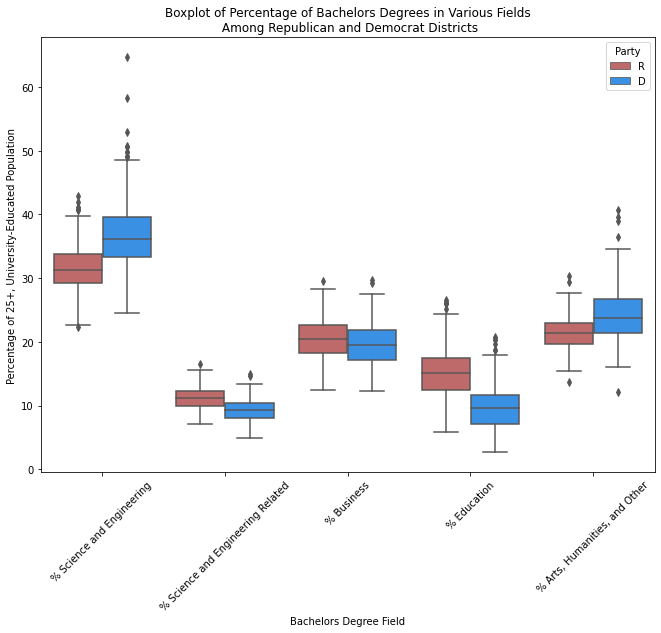

In [ ]:
# create color palette
palette = {'R': 'indianred', 
           'D': 'dodgerblue'}

# create plot
plt.figure(figsize=(11, 8))

bplot = sns.boxplot(data= df_melt, hue = 'Party', x = 'Degree Proportion', y = 'value', palette = palette)

plt.xticks(rotation = 45)

bplot.set(xlabel = 'Bachelors Degree Field',
          ylabel = 'Percentage of 25+, University-Educated Population',
          title = 'Boxplot of Percentage of Bachelors Degrees in Various Fields\n Among Republican and Democrat Districts')

This box plot demonstrates how Democrat districts have higher proportions of bachelor's degrees in Science/Engineering and Arts/Humanities/Other. Republican districts have higher proportions of bachelor's degrees in Science/Engineering Related fields and in Education. The proportion of bachelor's degrees in Business seems to be very similar among Republican and Democrat districts.

A swarm plot offers another view of the data. Here, we will see individual points for each observation. 

[Text(0, 0.5, 'Percentage of 25+, University-Educated Population'),
 Text(0.5, 0, 'Bachelors Degree Field'),
 Text(0.5, 1.0, 'Swarm Plot of Percentage of Bachelors Degrees in Various Fields\n Among Republican and Democrat Districts')]

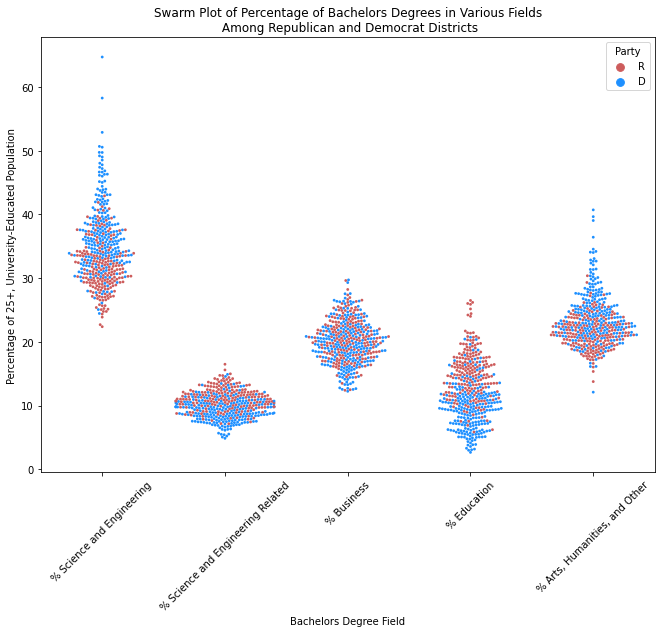

In [ ]:
#Swarm plot- shows a good visualization that for Sci/Engineering and Arts/Humanities the Democrats (blue)
#have higher proportions of total Pop over 25 earning that Degree Type vs Republicans
palette = {'R': 'indianred', 
           'D': 'dodgerblue'}

plt.figure(figsize=(11, 8))

bplot = sns.swarmplot(data= df_melt, hue = 'Party', size = 2.8, 
                      x = 'Degree Proportion', y = 'value', palette = palette)

plt.xticks(rotation = 45)

bplot.set(xlabel = 'Bachelors Degree Field',
          ylabel = 'Percentage of 25+, University-Educated Population',
          title = 'Swarm Plot of Percentage of Bachelors Degrees in Various Fields\n Among Republican and Democrat Districts')

# Interpretation of Graphs

It appears that our hypothesis that Democratic districts would have the highest proportions  of bachelor's degrees in Science/Engineering, and Arts/Humanities was partially confirmed. As shown by the boxplot and swarm plot above, the Science/Engineering as well as the Arts/Humanities Degree Categories had higher proportions of the total 25+ population in Democratic districts (larger concentrations of blue data points in the higher proportion values). Contrary to our hypothesis, we see that Republican districts had a greater proportion of bachelor's degrees in Education than the Democrat districts. We also see a larger proportion of bachelor's degrees in Education among the Republican districts, which we did not expect.

Meanwhile, the proportion of bachelor's degrees in Business seems to be about equal among Democrat and Republican districts, meaning that we cannot conclude our hypothesis that business would be dominated by Republicans was accurate.

We can provide a table of the mean and median values for each degree type to further demonstrate the differences among Republican and Democrat districts.



# Table of Mean and Median Proportion of Bachelor's Degrees in Each Field By Party

The table below provides the exact mean and median proportion of bachelor's degrees in each field among all Democrat and Republican districts.

In [ ]:
means_meds =merged_df.groupby('Party')[['% Science and Engineering', 
                                       '% Science and Engineering Related',
                                       '% Business', '% Education', 
                                       '% Arts, Humanities, and Other']].aggregate(['mean', 'median'])

In [ ]:
means_meds

% Science and Engineering            % Science and Engineering Related  \
                           mean     median                              mean   
Party                                                                          
D                     36.948589  36.080887                          9.293065   
R                     31.717346  31.316630                         11.177018   

                 % Business            % Education             \
          median       mean     median        mean     median   
Party                                                           
D       9.254653  19.688641  19.545711    9.721268   9.544656   
R      11.176513  20.513236  20.483732   15.168800  15.114102   

      % Arts, Humanities, and Other             
                               mean     median  
Party                                           
D                         24.348437  23.677883  
R                         21.423600  21.341020

# Statistical Significance of Results

To gain a better understanding of if the results we observed in our graphs and table are truly significant, we will perform z-tests to compare each party's proportion of bachelor's degrees in each field. A z-test can be used to compare proportions between two samples and find evidence as to whether the underlying populations are different from each other.

Using the statsmodels library, we will perform a z-test for each degree field, comparing the Republican and Democrat proportions. In each test, the **null** hypothesis is that the proportion of bachelor's degrees in a particular field earned by the 25+, bachelor's or higher-educated population is the same among Republican and Democrat districts. The **alternative** hypothesis is that the proportions are different. We will use a 0.01 significance level for these tests.

In [ ]:
# create subsets of the data by party affiliation
R = merged_df.loc[merged_df['Party'] == 'R']
D = merged_df.loc[merged_df['Party'] == 'D']

In [ ]:
cols = ['% Science and Engineering', '% Science and Engineering Related', '% Business', '% Education', '% Arts, Humanities, and Other']

# function to perform the two-sample z-test for each degree field, comparing Republican and Democrat districts
for x in cols:
  print("Test statistic and p-value for", x, ":\n", 
        ztest(R[x], D[x], value = 0))


Test statistic and p-value for % Science and Engineering :
 (-10.814786304485308, 2.9297467189236413e-27)
Test statistic and p-value for % Science and Engineering Related :
 (10.992256548915222, 4.163835629703087e-28)
Test statistic and p-value for % Business :
 (2.5517169479186173, 0.010719356451379631)
Test statistic and p-value for % Education :
 (15.025367400932971, 5.0082885587327403e-51)
Test statistic and p-value for % Arts, Humanities, and Other :
 (-8.523899343259037, 1.542697063782863e-17)


At the 0.01 significance level, four of the five tests we performed yielded significant results. **We have evidence to suggest there is a significant difference in the proportion of bachelor's degrees earned in Science/Engineering, Science/Engineering Related fields, Education, and Arts/Humanities/Other fields among Democrat and Republican districts.** However, at the 0.01 level, we do not have enough evidence to state that the proportion of bachelor's degrees earned in Business is significantly different among Democrat and Republican districts.

This analysis has provided several results which surprised us. Interestingly, the test which yielded the strongest results was that for Education, and the Republican districts have a significantly higher proportion of Bachelor's degrees in the Education field than the Democrat districts, which contradicts our hypothesis! It is also interesting to see that while the Democrat districts have a greater proportion of individuals who majored in Science/Engineering, the Republican districts have a greater proportion of individuals whose degrees were in a Science/Engineering Related field.

# Sources

Pierce's analysis of household income in congressional districts: https://github.com/jackalnom/congressional-analysis/blob/main/intro.ipynb

Bertelsen and Meltons' initial analysis of science and engineering degrees by state party affiliation: https://github.com/melissamelton/GSB521_CongressionalData/blob/main/Engineering_and_Science_Education_Among_States.ipynb

American Community Survey: https://www.census.gov/data/developers/data-sets/acs-1year.html

Congressional district party affiliations: http://goodcsv.com/politics/us-house-of-representatives-2020/